In [1]:
%load_ext notexbook

In [2]:
%texify

<span class="badges">

[![myBinder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/leriomaggio/deep-unsupervised-learning/HEAD?filepath=3_Dimensionality_Reduction/3%20UMAP%20Arithmetic.ipynb)
    
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/leriomaggio/deep-unsupervised-learning/blob/main/3_Dimensionality_Reduction/3%20UMAP%20Arithmetic.ipynb)

[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/leriomaggio/deep-unsupervised-learning/blob/main/3_Dimensionality_Reduction/3%20UMAP%20Arithmetic.ipynb)
</span>

<span class="fn"><i>[Note]: </i> This notebook has been designed using the [$\text{no}\TeX\text{book}$](https://github.com/leriomaggio/notexbook-jupyter-theme) Jupyter notebook theme. <br />
Please **Trust** the notebook to automatically enable the theme. If you are viewing this notebook in **Google Colab**, these are the [instructions](https://github.com/leriomaggio/notexbook-jupyter-theme/tree/texbook-colab) to enable the theme in Colab.</span>

# UMAP's Arithmetics

<span><i>Adapted from: </i> _Combining multiple UMAP models_ [(Ref)](https://umap-learn.readthedocs.io/en/latest/composing_models.html#combining-multiple-umap-models)</span>

It is possible to combine together multiple UMAP models, assuming that they are operating on the same underlying data. 
To get an idea of how this works recall that UMAP uses an intermediate fuzzy topological representation ([doc](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html#how-umap-works)). 

Given different views of the same underlying data this will generate different fuzzy topological representations. 
We can apply intersections or unions to these representations to get a new composite fuzzy topological representation which we can then embed into low dimensional space in the standard UMAP way. 

The key is that, to be able to sensibly intersect or union these representations, there must be one-to-one correspondences between the data samples from the two different views.

To get an idea of how this might work it is useful to see it in practice.

In [3]:
version = lambda p: print(f"{p.__name__}: {p.__version__}")

In [4]:
try: 
    import umap
except ImportError:
    print("Please install umap-learn to run this notebook: pip install umap-learn")
else:
    version(umap)

umap: 0.5.1


In [5]:
try:
    from umap import plot as umap_plot
except ImportError:
    print("Please install umap plot dependencies: pip install 'umap-learn[plot]'")

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
import numpy as np
from sklearn.datasets import fetch_openml, load_digits

###### Load MNIST dataset

In [8]:
# Set this flag to False and re-run the whole notebook to use 
# the Digits "Toy" dataset
USE_HIGH_RESOLUTION_DATA = True  # Using High-res by default

In [9]:
if USE_HIGH_RESOLUTION_DATA:
    # mnist_784 is the name of the dataset in OpenML
    # This may take some time depending on your internet connection
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    y = y.astype(int)
else:
    X, y = load_digits(return_X_y=True)

In [10]:
# Showing shapes of data
X.shape, y.shape

((70000, 784), (70000,))

In [11]:
X = X.to_numpy()
y = y.to_numpy()

#### UMAP Transformer for MNIST

In [12]:
mapper = umap.UMAP(random_state=123456).fit(X)

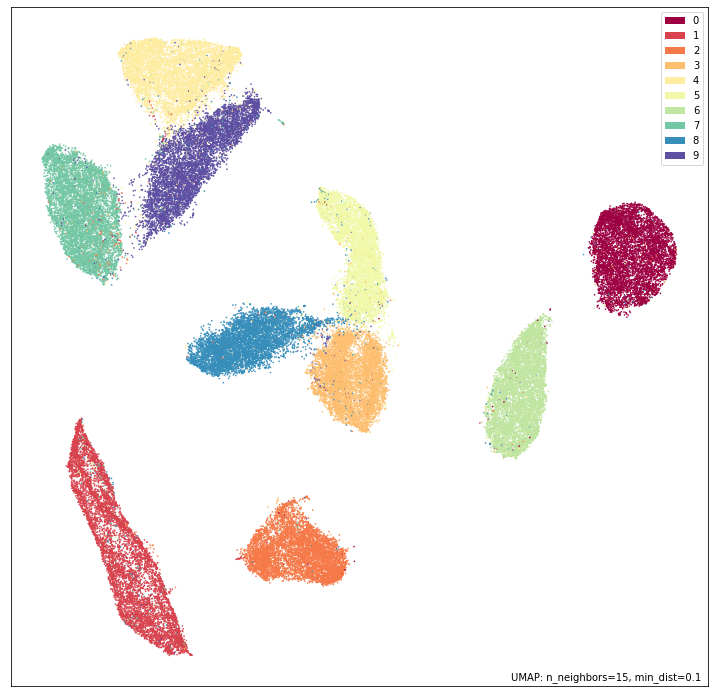

In [13]:
umap_plot.points(mapper, labels=y, width=900, height=900)
plt.show()

### Data Integration

To make the problem more interesting let’s carve the dataset in two – not into two sets of `35,000` samples, but instead carve each image in half. 

That is, we’ll end up with `70,000` samples each of which is the top half of the image of the handwritten digit, and another `70,000` samples each of which is the bottom half of the image of the handwritten digit.

In [14]:
top = X[:, :28 * 14]
bottom = X[:, 28 * 14:]

###### Note on Data (re)Composition

This is a little artificial, but it provides us with an example dataset where we have two distinct views of the data which we can still well understand. 

In practice this situation would be more likely to arise when there are two different data collection processes sampling from the same underlying population. 

In our case we could simply glue the data back together (`hstack` the numpy arrays would suffice), but potentially this isn’t feasible as the different data views may have different scales or modalities.

So, despite the fact that we could glue things back together in this case, we will proceed as if we can’t – as may be the case for many real world problems.


Let’s first look at what UMAP does individually on each dataset. We’ll start with the top halves of the digits:

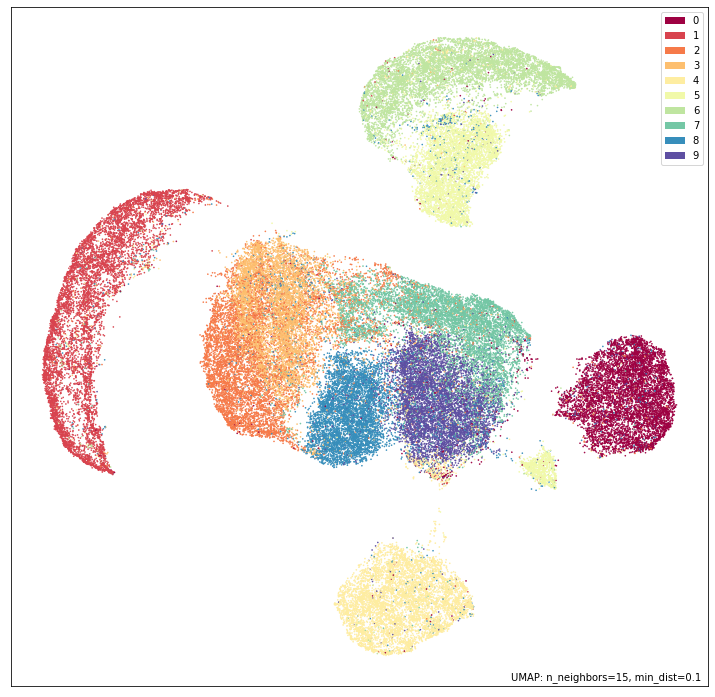

In [15]:
top_mapper = umap.UMAP(random_state=123456).fit(top)
umap_plot.points(top_mapper, labels=y, width=900, height=900)
plt.show()

While UMAP still manages to mostly separate the different digit classes we can see the results are quite different from UMAP on the full standard MNIST dataset. 

- The **twos** and **threes** are blurred together (as we would expect given that we don’t have the bottom half of the image wich would let us tell them apart); 

- The **twos** and **threes** are also in a large grouping that pulls together all of the eights, sevens and nines (again, what we would expect given only the top half of the digit), while the fives and sixes are somewhat distinct, but clearly are similar to each other. 

- It is only the ones, fours and zeros that are very clearly discernible.

Now let’s see what sorts of results we get with the bottom halves of the digits:

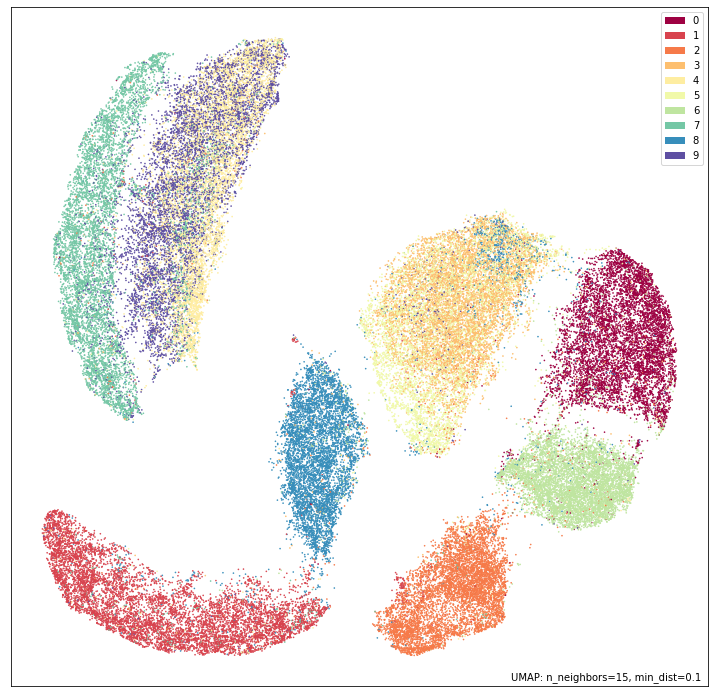

In [16]:
bot_mapper = umap.UMAP(random_state=123456).fit(bottom)
umap_plot.points(bot_mapper, labels=y, width=900, height=900)
plt.show()

This is clearly a very different view of the data. 

- Now it is the **fours** and **nines** that blur together, with **sevens** nearby. 

- The **twos** and the **threes** are very distinct from each other, but the threes and the fives are combined (as we might expect). 

- **Zeros** and **sixes** are distinct, but close to each other. 

- **Ones**, **eights** and **twos** are the most distinctive digits in this view.

So, assuming we **can’t just glue** the _raw data_ together and stick a reasonable metric on it, what can we do? 

We can perform _intersections_ or _unions_ on the fuzzy topological representations. 

There is also some work to be done re-asserting UMAP’s theoretical assumptions (local connectivity, approximately uniform distributions). 

Fortunately UMAP makes this relatively easy (as long as you have reference to the `mappers` you want to combine). 

To intersect two models simply use the `*` operator; to union them use the `+` operator. 

**Note** that this will actually take some time since we need to compute the 2D embedding of the combined model.

In [17]:
# This may take some time
intersection_mapper = top_mapper * bot_mapper
union_mapper = top_mapper + bot_mapper

With that complete we can visualize the results. 

First let’s look at the intersection:

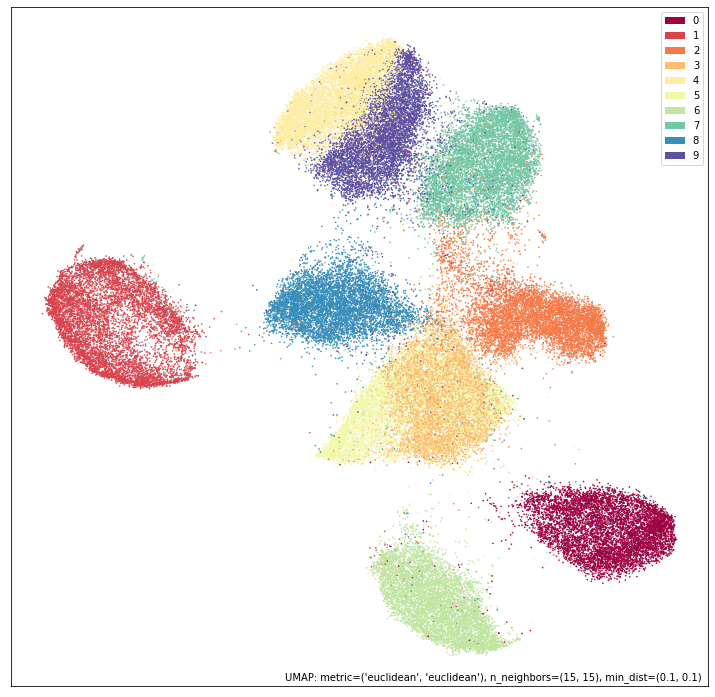

In [18]:
umap_plot.points(intersection_mapper, labels=y, width=900, height=900)
plt.show()

As you can see, while this isn’t as good as a UMAP plot for the full MNIST dataset it has recovered the individual digits quite well. 

The worst of the remaining overlap is between the threes and fives in the center, which is it still struggling to fully distinguish. 

⚠️But **note**, also, that we have recovered more of the overall structure than either of the two different individual views, with the layout of different digit classes more closely resembling that of the UMAP run on the full dataset.⚠️

Now let’s look at the union.

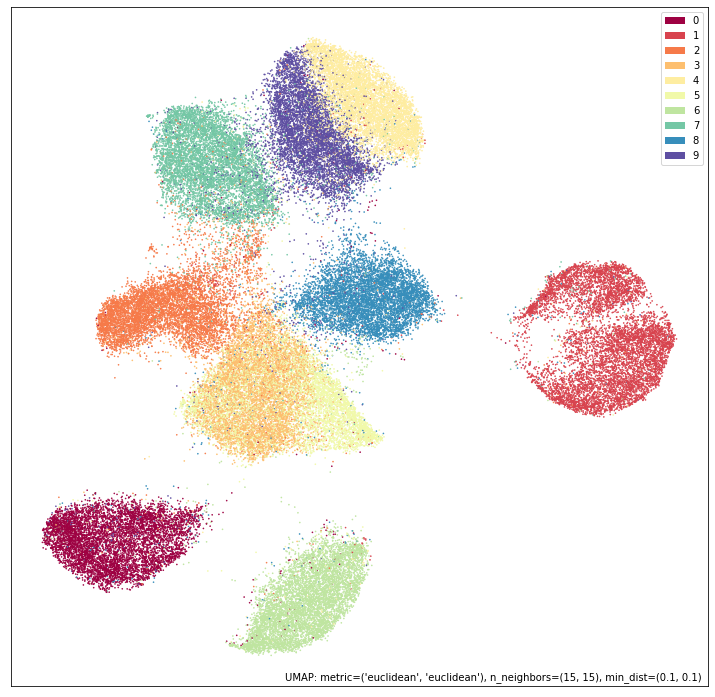

In [19]:
umap_plot.points(union_mapper, labels=y, width=900, height=900)
plt.show()

**This is an interesting result:** given that UMAP is agnostic to rotation or reflection of the final layout, this is essentially the same result as the intersection since it is almost the reflection of it in the y-axis. 

This (sort of) result (intersection and union being similar) is not always the case. In fact it is not that common! However, since the underlying structure of the digits dataset is so clear, we can find that either way of piecing it together from the two half datasets manage to find the same core underlying structure.

If we now finally compare with `umap` mapper on the full dataset:

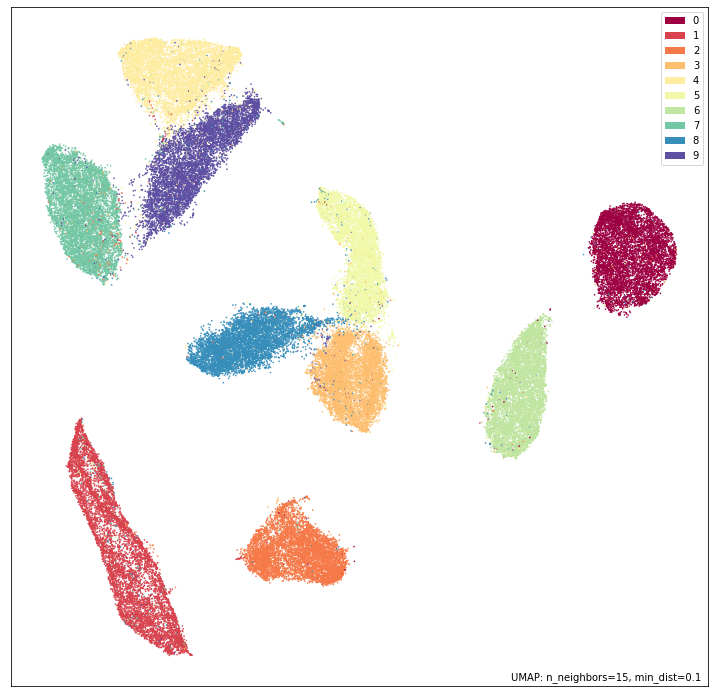

In [20]:
umap_plot.points(mapper, labels=y, width=900, height=900)
plt.show()

If you are willing to try something a little **more experimental** there is also a third option using the `-` operator which effectively intersects with the fuzzy set complement (and is thus not commutative, just as `-` implies). 

The goal here is to try to provide a sense of what the data looks like when we contrast it against a second view.

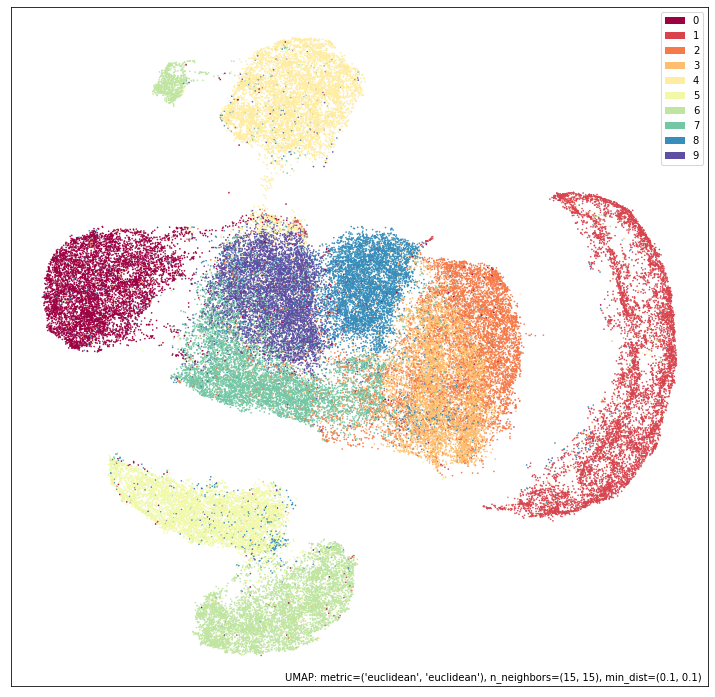

In [21]:
contrast_mapper = top_mapper - bot_mapper
umap_plot.points(contrast_mapper, labels=y, width=900, height=900)
plt.show()

In this case the result is not overly dissimilar from the embedding of just the top half, so the contrast has perhaps not shown is as much as we might have hoped.